In [1]:
from PIL import Image, ImageDraw
import albumentations as A
import cv2
import numpy as np
import random
import os
import shutil
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import Dataset, DataLoader, random_split

# Вспомогательная функция для удаления директории
def delete_directory(path: str):
    # Удаляет директорию по заданному пути, если она существует
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
        except OSError as e:
            print(f'[ERROR] Error deleting a directory: `{path}`: {e.strerror}')
            
# ======================================================================================== #            

# Класс аугментации пар картинка-аннотации на базе библиотеки albumentations
class ImageAugmentor:
    def __init__(self):
        self.augmentations = A.Compose([
                A.RandomCropFromBorders(p=0.33, crop_left=0.05, crop_right=0.05, crop_top=0.05, crop_bottom=0.05),
                A.Rotate(p=0.33, limit=7, interpolation=0, border_mode=4),
                A.ShiftScaleRotate(p=0.33, shift_limit_x=0.05, shift_limit_y=0.05, scale_limit=0.1, rotate_limit=0, interpolation=0, border_mode=4),
                A.HorizontalFlip(p=0.4),
                A.RGBShift(p=0.33, r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
                A.RandomBrightnessContrast(p=0.33),
#                A.CLAHE(p=0.33, clip_limit=(1, 4), tile_grid_size=(8, 8)),
                A.GaussNoise(p=0.33, var_limit=(10.0, 50.0), per_channel=True, mean=0.0),
#                A.ElasticTransform(p=0.25, alpha=1, sigma=20, alpha_affine=20), # Эластичные трансформации для деформации изображения
#                A.OpticalDistortion(p=0.25, distort_limit=0.02, shift_limit=0.02), # Оптическое искажение
#                A.CoarseDropout(p=0.33, max_holes=8, max_height=8, max_width=8) # Создает случайные пропущенные пиксели
        ], 
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
        )
        
    # Применение аугментаций к изображению, bbox
    def _apply_augmentations(self, image, bboxes, class_labels):
        try:
            augmented = self.augmentations(image=image, bboxes=bboxes, class_labels=class_labels)
            return augmented['image'], augmented['bboxes']
        except Exception as e:
            return image, bboxes

    # Метод для коррекции BBox-ов после аугментации
    def _correct_bboxes(self, class_labels, transformed_bboxes):
        corrected_bboxes = []
        for bbox, label in zip(transformed_bboxes, class_labels):
            # Переставляем метку класса на первое место в списке
            corrected_bbox = [label] + list(bbox)
            corrected_bboxes.append(corrected_bbox)
        return corrected_bboxes

    # Функция для аугментации одного изображения
    def _augment_single_image(self, img_with_bbox):
        img, bboxes = img_with_bbox
        img_array = np.array(img)  # Конвертируем PIL.Image в numpy array

        # Извлечение class_labels из bboxes
        class_labels = [bbox[0] for bbox in bboxes]
        bboxes_without_labels = [bbox[1:] for bbox in bboxes]

        # Применение аугментаций
        transformed_img, transformed_bboxes = self._apply_augmentations(
            img_array, bboxes_without_labels, class_labels)
              
        # Конвертируем обратно в PIL.Image после аугментаций
        transformed_img = Image.fromarray(transformed_img)

        # Коррекции bboxes
        corrected_bboxes = self._correct_bboxes(class_labels, transformed_bboxes)
        
        return (transformed_img, corrected_bboxes)

    # Основная функция аугментации всех доступных пар картинка-аннотации
    def augment_images(self, images_with_bboxes):
        if not self.augmentations:  # Проверяем, есть ли аугментации
            return images_with_bboxes  # Возвращаем изображения без изменений, если аугментаций нет

        # Использование многопоточности для аугментации изображений
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(self._augment_single_image, images_with_bboxes), total=len(images_with_bboxes), desc="Аугментация исходных фото", unit=" images"))

        return results
    
# ======================================================================================== #    

# Класс построения набора аннотированных мозаик    
class MosaicCreator:
    def __init__(self, canvas_size=640, min_image_size=40, large_image_threshold=512, process_large_images=False):
        self.canvas_size = canvas_size
        self.min_image_size = min_image_size
        self.large_image_threshold = large_image_threshold
        self.process_large_images = process_large_images

    # Функция для отрисовки bbox на исходном изображении
    def draw_source_bboxes(self, image, bboxes):
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:
            class_labels, x_center, y_center, width, height = bbox
            # Преобразование нормализованных координат обратно в абсолютные значения в пикселях
            absolute_x_center = x_center * image.size[0]
            absolute_y_center = y_center * image.size[1]
            absolute_width = width * image.size[0]
            absolute_height = height * image.size[1]

            # Вычисление координат углов прямоугольника
            left = absolute_x_center - absolute_width // 2
            top = absolute_y_center - absolute_height // 2
            right = absolute_x_center + absolute_width // 2
            bottom = absolute_y_center + absolute_height // 2

            draw.rectangle([left, top, right, bottom], outline="red", width=2)
        return image
    
    # Функция для нахождения пар изображение-метка        
    def find_image_label_pairs(self, src_directory):
        images = {}
        labels = {}

        # Получаем список всех файлов в директории и поддиректориях
        all_files = []
        for root, _, files in os.walk(src_directory):
            for file in files:
                all_files.append((root, file))

        # Проходим по всем файлам, используя прогресс-бар
        for root, file in tqdm(all_files, desc="Поиск пар изображений и меток", unit=" files"):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                base_name = os.path.splitext(file)[0]
                images[base_name] = os.path.join(root, file)
            elif file.lower().endswith('.txt'):
                base_name = os.path.splitext(file)[0]
                labels[base_name] = os.path.join(root, file)

        # Сопоставляем изображения и метки
        pairs = []
        for base_name, img_path in images.items():
            txt_path = labels.get(base_name)
            if txt_path:
                pairs.append((img_path, txt_path))

        return pairs
    
    # Функция загрузки всех аннотаций, которые есть на выбранной картинке
    def _load_bboxes(self, bbox_file_path):
        bboxes = []
        try:
            with open(bbox_file_path, 'r') as file:
                for line in file:
                    class_labels, x_center, y_center, width, height = map(float, line.strip().split())
                    bboxes.append([int(class_labels), x_center, y_center, width, height])
        except Exception as e:
            print(f"Ошибка при чтении файла аннотаций {bbox_file_path}: {e}")
        return bboxes              

    # Функция загрузки пар картинка-аннотации
    def _process_image(self, img_path, txt_path):
        try:
            # Загружаем картинки и их аннотации
            img = Image.open(img_path)
            original_width, original_height = img.size
            bboxes = self._load_bboxes(txt_path)

            # Проверяем, нужно ли обрабатывать большие изображения отдельно
            if self.process_large_images and (original_width >= self.large_image_threshold or original_height >= self.large_image_threshold):
                # Возвращаем изображение и его аннотации без изменений
                return img, bboxes
            else:
                # Погдонка больших изображений под размер полотна
                if original_width > self.canvas_size or original_height > self.canvas_size:
                    img.thumbnail((self.canvas_size, self.canvas_size), Image.Resampling.LANCZOS)
                return img, bboxes
        except Exception as e:
            print(f"Ошибка при открытии изображения {img_path}: {e}")
            return None, []

    # Функция загрузки и обработки пар изображений и аннотаций
    def process_image_label_pairs(self, image_label_pairs):
        if not hasattr(self, 'image_bbox_pairs') or not self.image_bbox_pairs:
            # Инициализируем списки для хранения данных, если они еще не созданы или пусты
            self.image_bbox_pairs = []
            self.large_images = []

            # Обработка пар изображений и аннотаций
            with concurrent.futures.ThreadPoolExecutor() as executor:
                futures = {executor.submit(self._process_image, img_path, label_path): idx for idx, (img_path, label_path) in enumerate(image_label_pairs)}
                for future in tqdm(futures, total=len(image_label_pairs), desc="Предобработка изображений", unit=" images", leave=True):
                    img, bboxes = future.result()
                    if img is not None and bboxes:
                        if self.process_large_images and (img.width >= self.large_image_threshold or img.height >= self.large_image_threshold):
                            self.large_images.append((img, bboxes)) # Сохраняем большие изображения отдельно
                        else:
                            self.image_bbox_pairs.append((img, bboxes))  # Сохраняем пару изображение-аннотация
        return self.image_bbox_pairs, self.large_images        
    
    # Функция проверки возможности размещения изображения на полотно
    def _can_place_image(self, x, y, img, occupied_areas, canvas):
        # Проверяем, что изображение не выходит за границы холста
        if x + img.width > self.canvas_size or y + img.height > self.canvas_size:
            return False

        # Проверяем перекрытие с уже размещенными изображениями
        for area in occupied_areas:
            if not (x + img.width <= area['left'] or x >= area['right'] or
                    y + img.height <= area['top'] or y >= area['bottom']):
                return False

        return True
    
    # Функция дозаполнения полотна мозаики случайными изображениями
    def _fill_extra_images(self, x, y, all_images, all_bboxes, occupied_areas, canvas, next_row_y, pbar, min_x, min_y, max_x, max_y, mosaic_bboxes):
        max_attempts_per_image = 10  # Максимальное количество попыток разместить одно изображение
        max_total_attempts = 50  # Максимальное общее количество попыток для всего полотна
        total_attempts = 0  # Общий счетчик попыток

        while all_images and total_attempts < max_total_attempts:
            attempts = 0  # Счетчик попыток размещения одного изображения

            # Пытаемся разместить случайное изображение в текущей позиции
            placed = False
            tried_indices = set()
            cnt_img = np.round(np.log(len(all_images)))

            while len(tried_indices) < cnt_img and not placed and attempts < max_attempts_per_image:
                img_index = random.randint(0, len(all_images) - 1)

                if img_index in tried_indices:
                    continue  # Пропускаем уже рассмотренные изображения

                tried_indices.add(img_index)
                extra_img, extra_bboxes = all_images[img_index], all_bboxes[img_index]

                # Проверяем, помещается ли изображение в оставшееся пространство на полотне
                if self._can_place_image(x, y, extra_img, occupied_areas, canvas):
                    canvas.paste(extra_img, (x, y))
                    min_x, min_y = min(min_x, x), min(min_y, y)
                    max_x, max_y = max(max_x, x + extra_img.width), max(max_y, y + extra_img.height)
                    occupied_areas.append({'left': x, 'top': y, 'right': x + extra_img.width, 'bottom': y + extra_img.height})

                    # Корректируем координаты bbox с учетом смещения изображения
                    self.shift_bbox(extra_img, extra_bboxes, x, y, mosaic_bboxes)

                    x += extra_img.width
                    next_row_y = max(next_row_y, y + extra_img.height)
                    placed = True  # Отмечаем, что изображение было успешно размещено
                    pbar.update(1)

                    del all_images[img_index]  # Удаляем из списка, чтобы не размещать повторно
                    del all_bboxes[img_index]
                else:
                    attempts += 1  # Увеличиваем счетчик попыток
            
            total_attempts += 1  # Увеличиваем общий счетчик попыток

            # Если не удалось разместить ни одно изображение, переходим на новую строку или завершаем заполнение
            if not placed:
                if y + next_row_y >= self.canvas_size or total_attempts >= max_total_attempts:  # Если нет места для новой строки или превышено максимальное количество попыток, завершаем заполнение
                    break
                else:  # Переходим на новую строку
                    x = 0
                    y = next_row_y
                    next_row_y = y

        return min_x, min_y, max_x, max_y


    # Функция центровки мозаики на полотне
    def _center_mosaic(self, canvas, min_x, min_y, max_x, max_y):
        mosaic_width = max_x - min_x
        mosaic_height = max_y - min_y
        # Рассчитываем смещения для центровки
        offset_x = (self.canvas_size - mosaic_width) // 2
        offset_y = (self.canvas_size - mosaic_height) // 2
        final_canvas = Image.new('RGB', (self.canvas_size, self.canvas_size), (0, 0, 0))
        final_canvas.paste(canvas, (offset_x, offset_y))
        return final_canvas, offset_x, offset_y
    
    # Функция коррекции координат bbox при перемещении изображения по полотну
    def shift_bbox(self, image, bboxes, x, y, mosaic_bboxes):
        for bbox in bboxes:
            class_labels, x_center, y_center, width, height = bbox
            # Преобразование нормализованных координат bbox в абсолютные значения в пикселях на исходной картинке
            absolute_x_center = x_center * image.width
            absolute_y_center = y_center * image.height
            absolute_width = width * image.width
            absolute_height = height * image.height
            # Преобразование в абсолютные координаты полотна
            absolute_x_center += x
            absolute_y_center += y
            # Преобразование bbox в относительные координаты полотна
            corrected_x_center = absolute_x_center / self.canvas_size
            corrected_y_center = absolute_y_center / self.canvas_size
            corrected_width = absolute_width / self.canvas_size
            corrected_height = absolute_height / self.canvas_size
            # Запись аннотации полотна
            corrected_bbox = [class_labels, corrected_x_center, corrected_y_center, corrected_width, corrected_height]
            mosaic_bboxes.append(corrected_bbox)    
    
    # Основная функция сборки мозаик и аннотаций
    def create_mosaic(self, image_bbox_pairs, large_images, augmentor=None):
        mosaics = []

        # Обработка больших изображений с аугментацией
        if augmentor and self.process_large_images:
            large_images = augmentor.augment_images(large_images)
            
        # Применяем аугментацию, если она включена
        if augmentor:
            image_bbox_pairs = augmentor.augment_images(image_bbox_pairs)                    

        # Сортировка пар изображение-аннотация по размеру изображения
        image_bbox_pairs.sort(key=lambda pair: pair[0].width * pair[0].height, reverse=True)
        
        # Разделение пар на отдельные списки изображений и аннотаций
        all_images, all_bboxes = zip(*image_bbox_pairs)
        # Преобразование кортежей обратно в списки
        all_images = list(all_images)
        all_bboxes = list(all_bboxes)        
        
        with tqdm(total=len(all_images), desc="Распределение картинок по мозаикам", unit=" images", leave=True) as pbar:
            while all_images:
                canvas = Image.new('RGB', (self.canvas_size, self.canvas_size), (0, 0, 0))
                mosaic_bboxes = []
                x, y = 0, 0
                next_row_y = 0
                occupied_areas = []
                min_x, min_y, max_x, max_y = self.canvas_size, self.canvas_size, 0, 0                          

                # Размещение первого элемента на полотно
                largest_img, largest_bboxes = all_images.pop(0), all_bboxes.pop(0)
                canvas.paste(largest_img, (x, y))
                min_x, min_y = min(min_x, x), min(min_y, y)
                max_x, max_y = max(max_x, x + largest_img.width), max(max_y, y + largest_img.height)               
                occupied_areas.append({'left': x, 'top': y, 'right': x + largest_img.width, 'bottom': y + largest_img.height})
                
                # Корректируем координаты bbox с учетом смещения изображения
                self.shift_bbox(largest_img, largest_bboxes, x, y, mosaic_bboxes)

                x += largest_img.width
                next_row_y = max(next_row_y, y + largest_img.height)
                pbar.update(1)
                del largest_img
                del largest_bboxes

                # Дозаполнение полотна
                min_x, min_y, max_x, max_y = self._fill_extra_images(x, y, all_images, all_bboxes, occupied_areas, canvas, next_row_y, pbar, min_x, min_y, max_x, max_y, mosaic_bboxes)

                # Центрируем мозаику
                centered_mosaic, offset_x, offset_y = self._center_mosaic(canvas, min_x, min_y, max_x, max_y)

                # Корректируем все BBox на полотне после центровки мозаики
                adjusted_mosaic_bboxes = []
                for bbox in mosaic_bboxes:
                    class_labels, x_center, y_center, width, height = bbox
                    corrected_x_center = x_center + offset_x / self.canvas_size
                    corrected_y_center = y_center + offset_y / self.canvas_size
                    corrected_bbox = [class_labels, corrected_x_center, corrected_y_center, width, height]
                    adjusted_mosaic_bboxes.append(corrected_bbox)

                mosaics.append((centered_mosaic, adjusted_mosaic_bboxes))

        return mosaics, large_images

# ======================================================================================== #    
            
# Класс разделения исходных данных на три набора обучения модели (train/val/test)
class SplitSubset:
    def __init__(self, image_bbox_pairs, split_ratio, tolerance=0.05):
        self.image_bbox_pairs = image_bbox_pairs
        self.split_ratio = split_ratio
        self.tolerance = tolerance  # Допустимое отклонение
        self.class_entities = self._count_class_entities()

    # Считаем общее количество сущностей каждого класса
    def _count_class_entities(self):
        class_entities = {}
        for _, bboxes in self.image_bbox_pairs:
            for bbox in bboxes:
                class_id = bbox[0]
                class_entities[class_id] = class_entities.get(class_id, 0) + 1
        return class_entities

    # Распределение сущностей по наборам согласно split_ratio
    def _distribute_entities(self):
        distributed_entities = {i: {} for i in range(len(self.split_ratio))}
        for class_id, total in self.class_entities.items():
            for i, ratio in enumerate(self.split_ratio):
                entities_count = int(total * ratio)
                tolerance_count = int(self.tolerance * total)
                distributed_entities[i][class_id] = max(entities_count - tolerance_count, 0)
        return distributed_entities
    
    # Выбор поднабора, куда лучше положить взятую картинку
    def _select_subset(self, class_counts, distributed_entities, remaining_entities):
        best_subset = -1
        min_difference = float('inf')
        for i, subset_entities in distributed_entities.items():
            difference = 0
            for class_id, count in class_counts.items():
                difference += abs((subset_entities[class_id] - count) - remaining_entities[class_id])
            if difference < min_difference:
                min_difference = difference
                best_subset = i
        return best_subset 

    # Основная функция стратифицированного распределения сущностей по поднаборам
    def split(self):
        subsets = [[] for _ in self.split_ratio]
        remaining_entities = self.class_entities.copy()
        distributed_entities = self._distribute_entities()
        random.shuffle(self.image_bbox_pairs)

        for img, bboxes in tqdm(self.image_bbox_pairs, desc="Splitting data", unit=" pair"):
            class_counts = {class_id: 0 for class_id in self.class_entities}
            for bbox in bboxes:
                class_id = bbox[0]
                class_counts[class_id] += 1
            best_subset = self._select_subset(class_counts, distributed_entities, remaining_entities)
            if best_subset != -1:
                subsets[best_subset].append((img, bboxes))
                for class_id, count in class_counts.items():
                    remaining_entities[class_id] -= count
                    distributed_entities[best_subset][class_id] -= count
            else:
                min_size = min(len(subset) for subset in subsets)
                for subset in subsets:
                    if len(subset) == min_size:
                        subset.append((img, bboxes))
                        break

        return subsets
    
    # Функция для подсчета количества аннотаций по каждому классу в предоставленном поднаборе данных
    def count_annotations_by_class(self, dataset):
        class_counts = {}
        for _, bboxes in dataset:
            for bbox in bboxes:
                class_id = bbox[0]
                class_counts[class_id] = class_counts.get(class_id, 0) + 1
        # Сортировка словаря по ключам
        sorted_class_counts = dict(sorted(class_counts.items()))
        return sorted_class_counts    
    
# ======================================================================================== #    
            
# Класс Dataset для работы с DataLoader        
class YoloDataset(Dataset):
    def __init__(self, image_bbox_pairs):
        self.image_bbox_pairs = image_bbox_pairs

    def __len__(self):
        return len(self.image_bbox_pairs)

    def __getitem__(self, idx):
        image, bboxes = self.image_bbox_pairs[idx]
        return image, bboxes
    
# ======================================================================================== #    

# Формирующие функции

# Создание мозаик для каждого набора train/val/test
def create_mosaics(image_bbox_pairs, augmentor=None):
    # Разделение входных данных на малые и большие изображения
    processed_pairs = []
    large_images = []
    for pair in image_bbox_pairs:
        if pair[0].size[0] < mosaic_creator.large_image_threshold and pair[0].size[1] < mosaic_creator.large_image_threshold:
            processed_pairs.append(pair)
        else:
            large_images.append(pair)
    
    mosaics, large_images = mosaic_creator.create_mosaic(processed_pairs, large_images, augmentor=augmentor)
    all_images = mosaics + large_images
    return all_images
       
# Сохранение итоговых обучающих наборов мозаик и аннотаций
def save_mosaics(all_images, yolo_directory, bbox_directory):
    images_directory = os.path.join(yolo_directory, 'images')
    labels_directory = os.path.join(yolo_directory, 'labels')
    delete_directory(images_directory)
    os.makedirs(images_directory, exist_ok=True)
    delete_directory(labels_directory)
    os.makedirs(labels_directory, exist_ok=True)
    delete_directory(bbox_directory)
    os.makedirs(bbox_directory, exist_ok=True)
    for idx, (image, bboxes) in tqdm(enumerate(all_images), total=len(all_images), desc="Формирование и сохранение мозаик и больших картинок", unit=" unit"):
        # Сохранение мозаики
        mosaic_image_path = os.path.join(images_directory, f'image_{idx}.jpg')
        image.save(mosaic_image_path)

        # Сохранение аннотации
        annotation_path = os.path.join(labels_directory, f'image_{idx}.txt')
        with open(annotation_path, 'w') as file:
            for bbox in bboxes:
                file.write(' '.join(map(str, bbox)) + '\n')

        # Сохранение визуализации аннотированных изображений с рамками
        annotated_img = mosaic_creator.draw_source_bboxes(image, bboxes)
        annotated_img_path = os.path.join(bbox_directory, f'image_{idx}.jpg')
        annotated_img.save(annotated_img_path)

# Глобальные переменные для фиксации проверочных и тестовых наборов dataloaders
global_valid_loader = None
global_test_loader = None
   
# Функция для первичного и последующего создания DataLoader'ов
def initialize_dataloaders(first_epoch, batch_size=4):
    global global_valid_loader, global_test_loader, valid_dataset, test_dataset

    # При первом вызове создаем все DataLoader'ы
    if first_epoch or not global_valid_loader or not global_test_loader:
        # Создаем мозаики для каждого набора данных
        valid_mosaics = create_mosaics(valid_set, augmentor=None)
        test_mosaics = create_mosaics(test_set, augmentor=None)

        # Инициализация YoloDataset с мозаиками
        valid_dataset = YoloDataset(valid_mosaics)
        test_dataset = YoloDataset(test_mosaics)

        # Создание DataLoader'ов
        global_valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
        global_test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Создаем train_loader в любом случае
    train_mosaics = create_mosaics(train_set, augmentor=augmentor)
    train_dataset = YoloDataset(train_mosaics)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return {
        "Обучение": train_loader, 
        "Валидация": global_valid_loader, 
        "Тестирование": global_test_loader,
        "train_dataset": train_dataset,
        "valid_dataset": valid_dataset,
        "test_dataset": test_dataset
    }
        
# ======================================================================================== #
# ==================================== Основное тело ===================================== #
# ======================================================================================== #    
    
# Путь для yolo мозаик
yolo_directory = r'C:\Users\anton\UII\AZavod_Ural\Mosaic'
#yolo_directory = r'C:\Users\anton\UII\Smart_city\Mosaic'
delete_directory(yolo_directory)
os.makedirs(yolo_directory, exist_ok=True)

# Путь для визуализации мозаик с наложенными bbox
bbox_directory = r'C:\Users\anton\UII\AZavod_Ural\Annotated_Mosaic'
#bbox_directory = r'C:\Users\anton\UII\Smart_city\Annotated_Mosaic'
delete_directory(bbox_directory)
os.makedirs(bbox_directory, exist_ok=True)

# Создание экземпляров классов
augmentor = ImageAugmentor()
mosaic_creator = MosaicCreator(canvas_size=640, min_image_size=40, large_image_threshold=720, process_large_images=False)

# Загрузка пар изображение-метка
#src_directory = r'C:\Users\anton\UII\AZavod_Ural'
#src_directory = r'C:\Users\anton\UII\Smart_city'
src_directory = r'C:\Users\anton\UII'
image_label_path = mosaic_creator.find_image_label_pairs(src_directory)
image_bbox_pairs, large_images = mosaic_creator.process_image_label_pairs(image_label_path)
all_image_bbox_pairs = image_bbox_pairs + large_images

# Распределение исходных аннотированных пар на три набора обучения
splitter = SplitSubset(all_image_bbox_pairs, split_ratio=(0.7, 0.2, 0.1)) # Задаем пропорции наборов данных
train_set, valid_set, test_set = splitter.split()

Splitting data: 100%|██████████| 8469/8469 [00:00<00:00, 58401.72 pair/s]


In [2]:
# Параметры обучения

batch_size = 32
epochs = 10

In [3]:
# Создание DataLoader'ов для первой эпохи
dataloaders = initialize_dataloaders(first_epoch=True, batch_size=batch_size)

Распределение картинок по мозаикам: 100%|██████████| 5837/5837 [00:08<00:00, 711.22 images/s] 


In [4]:
# ==================================== Контроль ===================================== #

# Проверка количества изображений в каждом наборе
print(f"Train set: {len(train_set)} images")
print(f"Validation set: {len(valid_set)} images")
print(f"Test set: {len(test_set)} images\n")

# Проверим стратификацию поднаборов по классам
train_annotations = splitter.count_annotations_by_class(train_set)
valid_annotations = splitter.count_annotations_by_class(valid_set)
test_annotations = splitter.count_annotations_by_class(test_set)
print("Количество аннотаций в train наборе:", train_annotations)
print("Количество аннотаций в valid наборе:", valid_annotations)
print("Количество аннотаций в test наборе:", test_annotations)

# Сохранение наборов аннотированных мозаик по структуре папок для визуального контроля. Для обучения убрать.
save_mosaics(dataloaders["train_dataset"], os.path.join(yolo_directory, 'train'), os.path.join(bbox_directory, 'train'))
save_mosaics(dataloaders["valid_dataset"], os.path.join(yolo_directory, 'valid'), os.path.join(bbox_directory, 'valid'))
save_mosaics(dataloaders["test_dataset"], os.path.join(yolo_directory, 'test'), os.path.join(bbox_directory, 'test'))

Train set: 5837 images
Validation set: 1749 images
Test set: 883 images

Количество аннотаций в train наборе: {0: 445, 2: 16968, 4: 973, 5: 184, 7: 1534, 9: 1503, 10: 228, 11: 793, 12: 384}
Количество аннотаций в valid наборе: {0: 132, 2: 4759, 4: 333, 5: 70, 7: 415, 9: 409, 10: 70, 11: 230, 12: 169}
Количество аннотаций в test наборе: {0: 59, 2: 2383, 4: 140, 5: 32, 7: 226, 9: 232, 10: 31, 11: 136, 12: 57}


Формирование и сохранение мозаик и больших картинок: 100%|██████████| 5006/5006 [01:43<00:00, 48.57 unit/s]
Формирование и сохранение мозаик и больших картинок: 100%|██████████| 1550/1550 [00:30<00:00, 50.88 unit/s]
Формирование и сохранение мозаик и больших картинок: 100%|██████████| 768/768 [00:15<00:00, 50.11 unit/s]


In [5]:
# Создание DataLoader'ов для последующих эпох (эмуляция обучения)
for i in range(epochs-1):
    dataloaders = initialize_dataloaders(first_epoch=False, batch_size=batch_size)
print('Batches для обучения: ', len(dataloaders["Обучение"]),'\n',
      'Batches для валидации: ', len(dataloaders["Валидация"]),'\n',
      'Batches для тестирования: ', len(dataloaders["Тестирование"]),'\n', '\n',
      'Мозаик для обучения: ', len(dataloaders["train_dataset"]),'\n',
      'Мозаик для валидации: ', len(dataloaders["valid_dataset"]),'\n',
      'Мозаик для тестирования: ', len(dataloaders["test_dataset"]))

Распределение картинок по мозаикам: 100%|██████████| 5837/5837 [00:08<00:00, 715.32 images/s] 


Batches для обучения:  157 
 Batches для валидации:  49 
 Batches для тестирования:  24 
 
 Мозаик для обучения:  5005 
 Мозаик для валидации:  1550 
 Мозаик для тестирования:  768


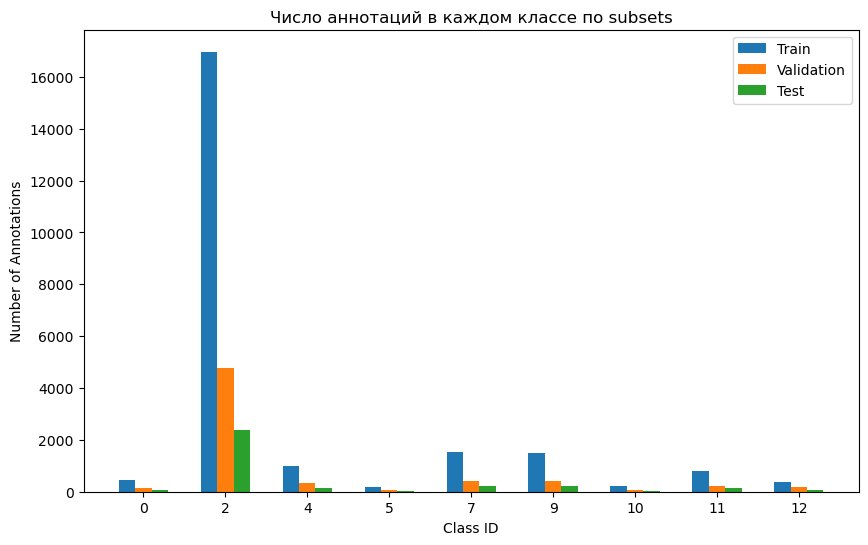

In [6]:
import matplotlib.pyplot as plt

# Получаем список всех классов
all_classes = sorted(set(train_annotations.keys()) | set(valid_annotations.keys()) | set(test_annotations.keys()))

# Данные для графика
train_values = [train_annotations.get(cls, 0) for cls in all_classes]
valid_values = [valid_annotations.get(cls, 0) for cls in all_classes]
test_values = [test_annotations.get(cls, 0) for cls in all_classes]

# Позиции для столбцов на графике
x = range(len(all_classes))
width = 0.2

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], train_values, width=width, label='Train')
plt.bar(x, valid_values, width=width, label='Validation')
plt.bar([i + width for i in x], test_values, width=width, label='Test')

# Настройки графика
plt.xlabel('Class ID')
plt.ylabel('Number of Annotations')
plt.title('Число аннотаций в каждом классе по subsets')
plt.xticks(x, all_classes)
plt.legend()

# Отображение графика
plt.show()
